In [42]:
import pandas as pd
import io
import numpy as np
import os
from pathlib import Path
from google.colab import files

print("Please upload your CSV file(s).")

uploaded = files.upload()


Please upload your CSV file(s).


Saving drive-download-20251231T195750Z-1-001.zip to drive-download-20251231T195750Z-1-001.zip


In [43]:

# Canonical data directory
CONTENT = Path("/content")

# Canonical filenames we want to keep
KEEP_FILES = {
    "belief_trace__kalshi__cuomo.csv",
    "belief_trace__kalshi__pope.csv",
    "belief_trace__kalshi__house.csv",
    "cuomo_gtrends_timeline.csv",
    "pope_gtrends_timeline.csv",
    "epstein_gtrends_timeline.csv",
}

# --------------------------------------------------
# Step 1: Fix known filename typo (grends → gtrends)
# --------------------------------------------------
for f in CONTENT.glob("cuomo_grends_timeline*.csv"):
    target = CONTENT / "cuomo_gtrends_timeline.csv"

    if not target.exists():
        os.rename(f, target)
    else:
        os.remove(f)

# --------------------------------------------------
# Step 2: Remove duplicate uploads ((1), (2), etc.)
# --------------------------------------------------
for f in CONTENT.iterdir():
    if f.is_file() and f.name not in KEEP_FILES:
        os.remove(f)
DATA_DIR = Path("/content")

print("Files in /content:\n")
for f in DATA_DIR.iterdir():
    print(f.name)



Files in /content:

.config
pope_gtrends_timeline.csv
belief_trace__kalshi__pope.csv
cuomo_gtrends_timeline.csv
epstein_gtrends_timeline.csv
belief_trace__kalshi__house.csv
belief_trace__kalshi__cuomo.csv
sample_data


In [44]:
def compute_belief_dynamics(df):
    df = df.copy()

    # Week-to-week belief change
    df["belief_change"] = df["belief_mean"].diff()
    df["abs_belief_change"] = df["belief_change"].abs()

    # Rolling volatility (3-week window)
    df["belief_vol_3w"] = df["belief_mean"].rolling(3).std()

    return df

In [48]:
import pandas as pd

def load_gtrends(path):
    """
    Load a Google Trends CSV exported from trends.google.com
    """
    df = pd.read_csv(
        path,
        skiprows=1,        # <-- THIS FIXES EVERYTHING
        parse_dates=[0]
    )

    # Standardize column names
    df.columns = ["date", "interest"]

    # Ensure numeric
    df["interest"] = pd.to_numeric(df["interest"], errors="coerce")

    return df.sort_values("date").reset_index(drop=True)


# TEST on one file first
cuomo_trends = load_gtrends("/content/cuomo_gtrends_timeline.csv")

cuomo_trends.head(), cuomo_trends.tail()


(        date  interest
 0 2024-12-29         3
 1 2025-01-05         4
 2 2025-01-12         4
 3 2025-01-19         4
 4 2025-01-26         4,
          date  interest
 48 2025-11-30         3
 49 2025-12-07         3
 50 2025-12-14         3
 51 2025-12-21         3
 52 2025-12-28         3)

In [49]:
gtrends = {
    "cuomo": load_gtrends("/content/cuomo_gtrends_timeline.csv"),
    "pope": load_gtrends("/content/pope_gtrends_timeline.csv"),
    "epstein": load_gtrends("/content/epstein_gtrends_timeline.csv"),
}

for k, df in gtrends.items():
    print(f"{k.upper()} trends")
    print(f"  Range: {df.date.min().date()} → {df.date.max().date()}")
    print(f"  Rows: {len(df)}")
    print("-" * 40)


CUOMO trends
  Range: 2024-12-29 → 2025-12-28
  Rows: 53
----------------------------------------
POPE trends
  Range: 2024-04-14 → 2025-05-04
  Rows: 56
----------------------------------------
EPSTEIN trends
  Range: 2025-11-01 → 2025-11-19
  Rows: 19
----------------------------------------


In [50]:
import pandas as pd

def load_belief_trace(path):
    """
    Load a Kalshi belief trace CSV.
    Expects columns: time, price, volume, open_interest
    """
    df = pd.read_csv(path, parse_dates=["time"])
    df = df.sort_values("time").reset_index(drop=True)

    # Rename for consistency
    df = df.rename(columns={"time": "date", "price": "belief"})

    # Drop empty belief rows (market inactivity)
    df = df.dropna(subset=["belief"])

    return df


belief_traces = {
    "cuomo": load_belief_trace("/content/belief_trace__kalshi__cuomo.csv"),
    "pope": load_belief_trace("/content/belief_trace__kalshi__pope.csv"),
    "house": load_belief_trace("/content/belief_trace__kalshi__house.csv"),
}

for k, df in belief_traces.items():
    print(f"{k.upper()} belief trace")
    print(f"  Range: {df.date.min()} → {df.date.max()}")
    print(f"  Rows: {len(df)}")
    print("-" * 40)

CUOMO belief trace
  Range: 2025-09-05 02:00:00 → 2025-11-04 00:00:00
  Rows: 798
----------------------------------------
POPE belief trace
  Range: 2025-04-25 15:00:00 → 2025-05-08 00:00:00
  Rows: 70
----------------------------------------
HOUSE belief trace
  Range: 2025-11-15 23:00:00 → 2025-11-18 00:00:00
  Rows: 10
----------------------------------------


In [51]:
def weekly_belief(df):
    """
    Aggregate belief trace to weekly frequency.
    """
    w = (
        df
        .set_index("date")
        .resample("W")
        .agg({
            "belief": "mean",
            "volume": "sum",
            "open_interest": "mean"
        })
        .reset_index()
    )

    return w


weekly_beliefs = {
    k: weekly_belief(df)
    for k, df in belief_traces.items()
}

for k, df in weekly_beliefs.items():
    print(f"{k.upper()} weekly belief")
    print(f"  Range: {df.date.min().date()} → {df.date.max().date()}")
    print(f"  Rows: {len(df)}")
    print("-" * 40)


CUOMO weekly belief
  Range: 2025-09-07 → 2025-11-09
  Rows: 10
----------------------------------------
POPE weekly belief
  Range: 2025-04-27 → 2025-05-11
  Rows: 3
----------------------------------------
HOUSE weekly belief
  Range: 2025-11-16 → 2025-11-23
  Rows: 2
----------------------------------------


In [52]:
aligned = {}

for case in ["cuomo", "pope", "epstein"]:
    belief = weekly_beliefs[case if case != "epstein" else "house"]
    trends = gtrends[case]

    merged = pd.merge(
        belief,
        trends,
        on="date",
        how="inner"
    )

    aligned[case] = merged

    print(f"{case.upper()} aligned")
    print(f"  Rows: {len(merged)}")
    print(merged.head(3))
    print("-" * 50)


CUOMO aligned
  Rows: 10
        date    belief  volume  open_interest  interest
0 2025-09-07  0.045862   39930  102457.586207         7
1 2025-09-14  0.042703   11044  107867.702703         5
2 2025-09-21  0.044286    4196  103878.371429         5
--------------------------------------------------
POPE aligned
  Rows: 2
        date    belief  volume  open_interest  interest
0 2025-04-27  0.381818    1010     763.545455        17
1 2025-05-04  0.363333    2269    1722.966667       100
--------------------------------------------------
EPSTEIN aligned
  Rows: 1
        date  belief  volume  open_interest  interest
0 2025-11-16    0.41     250          250.0        45
--------------------------------------------------


In [53]:
import numpy as np

def detect_belief_collapse(df, threshold=0.02):
    """
    Detect belief collapse as sustained low volatility.
    """
    df = df.copy()

    # Week-to-week belief change
    df["belief_change"] = df["belief"].diff().abs()

    # Rolling volatility
    df["belief_vol_3w"] = df["belief_change"].rolling(3).mean()

    # Collapse when volatility drops below threshold
    collapse = df[df["belief_vol_3w"] < threshold]

    collapse_time = collapse["date"].iloc[0] if not collapse.empty else np.nan

    return {
        "num_observations": len(df),
        "belief_volatility_mean": df["belief_vol_3w"].mean(),
        "belief_max_jump": df["belief_change"].max(),
        "inactive_fraction": df["belief_change"].isna().mean(),
        "collapse_time": collapse_time,
    }


collapse_stats = {}

for case, df in aligned.items():
    collapse_stats[case] = detect_belief_collapse(df)

pd.DataFrame(collapse_stats).T


,num_observations,belief_volatility_mean,belief_max_jump,inactive_fraction,collapse_time
cuomo,10,0.004088,0.015776,0.1,2025-09-28 00:00:00
pope,2.0,NaN,0.018485,0.5,NaN
epstein,1.0,NaN,NaN,1.0,NaN


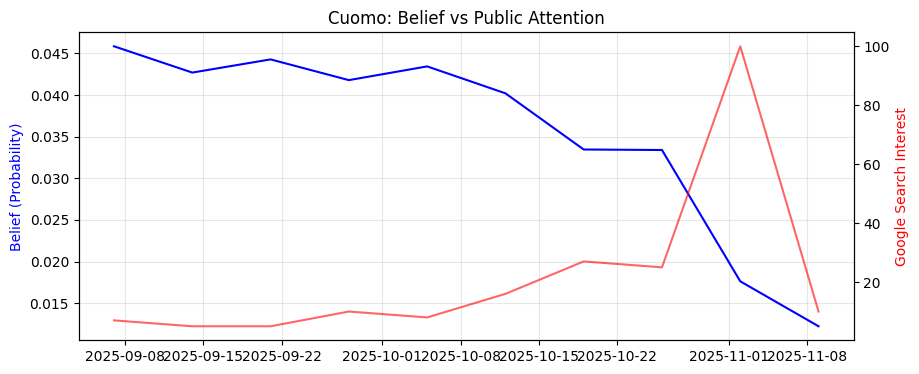

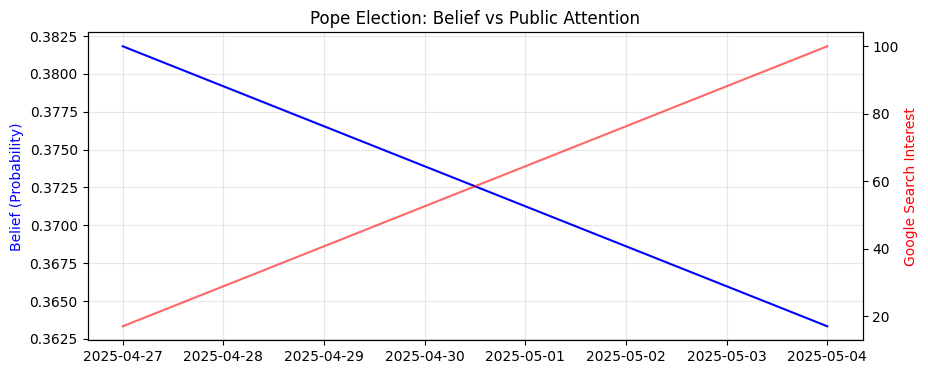

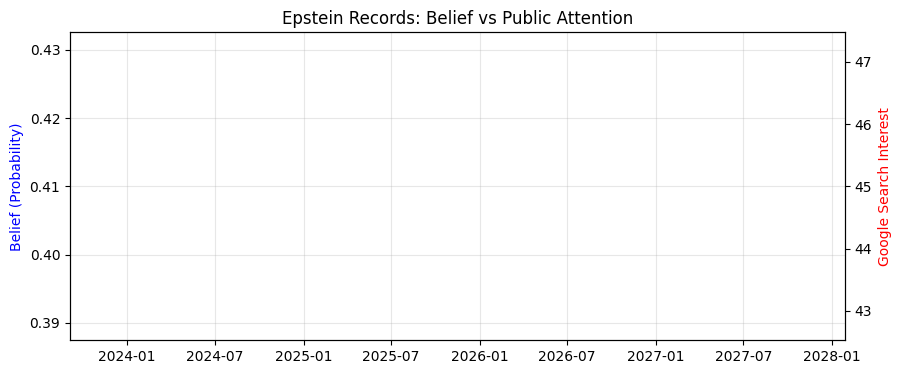

In [54]:
import matplotlib.pyplot as plt

def plot_belief_vs_attention(df, title):
    fig, ax1 = plt.subplots(figsize=(10, 4))

    ax1.plot(df["date"], df["belief"], color="blue", label="Market Belief")
    ax1.set_ylabel("Belief (Probability)", color="blue")

    ax2 = ax1.twinx()
    ax2.plot(df["date"], df["interest"], color="red", alpha=0.6, label="Search Interest")
    ax2.set_ylabel("Google Search Interest", color="red")

    ax1.set_title(title)
    ax1.grid(alpha=0.3)

    plt.show()


plot_belief_vs_attention(aligned["cuomo"], "Cuomo: Belief vs Public Attention")
plot_belief_vs_attention(aligned["pope"], "Pope Election: Belief vs Public Attention")
plot_belief_vs_attention(aligned["epstein"], "Epstein Records: Belief vs Public Attention")


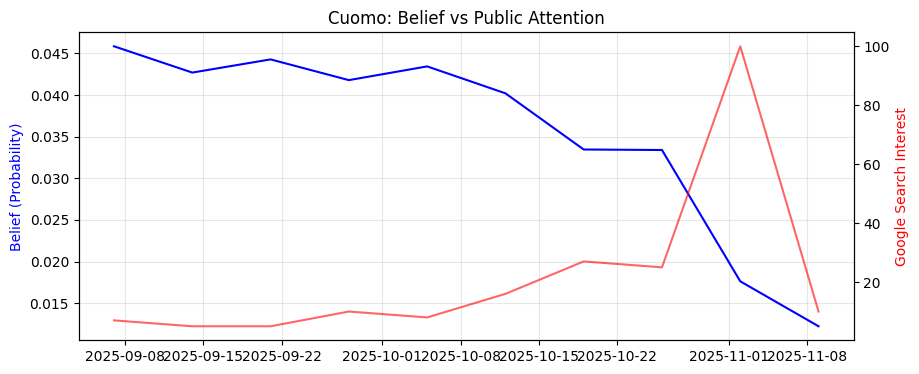

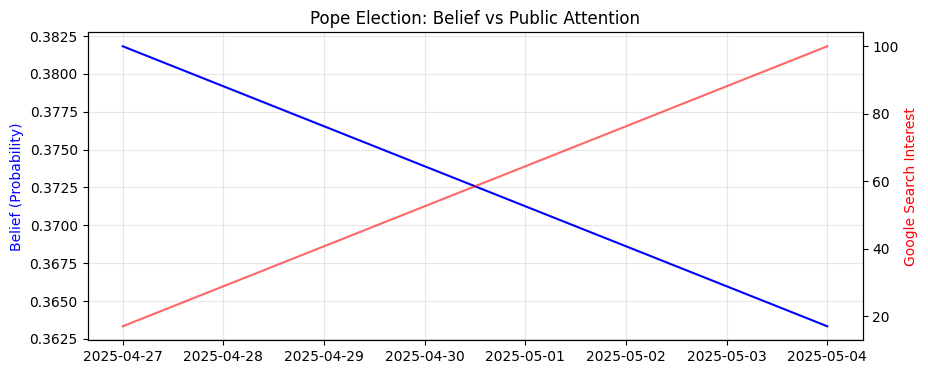

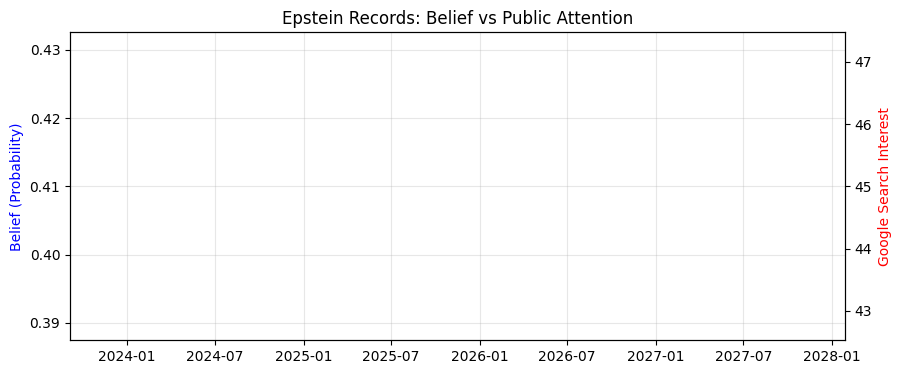

In [55]:
import matplotlib.pyplot as plt

def plot_belief_vs_attention(df, title):
    fig, ax1 = plt.subplots(figsize=(10, 4))

    ax1.plot(df["date"], df["belief"], color="blue", label="Market Belief")
    ax1.set_ylabel("Belief (Probability)", color="blue")

    ax2 = ax1.twinx()
    ax2.plot(df["date"], df["interest"], color="red", alpha=0.6, label="Search Interest")
    ax2.set_ylabel("Google Search Interest", color="red")

    ax1.set_title(title)
    ax1.grid(alpha=0.3)

    plt.show()


plot_belief_vs_attention(aligned["cuomo"], "Cuomo: Belief vs Public Attention")
plot_belief_vs_attention(aligned["pope"], "Pope Election: Belief vs Public Attention")
plot_belief_vs_attention(aligned["epstein"], "Epstein Records: Belief vs Public Attention")
